In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from functools import partial
import matplotlib.pyplot as plt
from plotnine import *
from mizani.formatters import *

def poly_func(x, *coefs):
  return sum([coefs[i] * x**i for i in range(len(coefs))])

def exp_func(x, b0, b1, b2):
    return b0 * np.exp(b1 * x) + b2

def get_prediction(func, cutting_point=33, nb_coefs = 3, valid_interval=5, show_plot=True):
  x_train = np.array(th.index[:cutting_point+1])
  y_train = np.array(th.total_cases[:cutting_point+1])
  x_valid = np.array(th.index[cutting_point:])
  y_valid = np.array(th.total_cases[cutting_point:])

  coefs, _ = curve_fit(func, x_train, y_train, p0=np.ones(nb_coefs))
  y_pred = np.array([func(i,*coefs) for i in x_valid])
  y_fit = np.array([func(i,*coefs) for i in x_train])
  
  if show_plot:
    print(f'Total MSE: {np.mean((y_pred-y_valid)**2):.2f}; Total MAPE: {100*np.mean(abs(y_pred-y_valid)/y_valid):.2f}%')
    print(f'{valid_interval}-day MSE: {np.mean((y_pred[:valid_interval]-y_valid[:valid_interval])**2):.2f}; {valid_interval}-day MAPE: {np.mean(abs(y_pred[:valid_interval]-y_valid[:valid_interval])/y_valid[:valid_interval]):.2f}%')
    plot_df = pd.DataFrame({'day':np.concatenate([x_train,x_valid]),
                            'prediction':np.concatenate([y_fit,y_pred]),
                            'ground_truth':np.concatenate([y_train,y_valid])}).melt(id_vars='day')
    g = (ggplot(plot_df,aes(x='day',y='value',color='variable')) + geom_line() +
        geom_vline(xintercept=cutting_point,linetype="dashed") + theme_minimal()+
        annotate(geom="text", x=cutting_point-10,y=500, label='Training Peroid') +
        annotate(geom="text", x=cutting_point+10,y=500, label='Prediction Peroid') +
        coord_cartesian(xlim=(0,50))+
        ylab('Total Cases') + xlab('Days Since First Case'))
    g.draw()
  
    # plt.plot(x_train,y_train)
    # plt.plot(x_valid,y_valid)
    # plt.plot(x_train,y_fit)
    # plt.plot(x_valid,y_pred)

  return np.mean((y_pred-y_valid)**2), np.mean(abs(y_pred-y_valid)/y_valid), \
    np.mean((y_pred[:valid_interval]-y_valid[:valid_interval])**2), \
    np.mean(abs(y_pred[:valid_interval]-y_valid[:valid_interval])/y_valid[:valid_interval])

In [15]:
df = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
th = df[df.location=='Thailand'].tail(40).reset_index(drop=True).reset_index()
th.tail()

,index,date,location,new_cases,new_deaths,total_cases,total_deaths
35,35,2020-03-26,Thailand,111,0,1045,4
36,36,2020-03-27,Thailand,91,1,1136,5
37,37,2020-03-28,Thailand,0,0,1136,5
38,38,2020-03-29,Thailand,109,1,1245,6
39,39,2020-03-30,Thailand,143,1,1388,7


In [16]:
#th.to_csv('thanland_total_data.csv') 

Total MSE: 35680.51; Total MAPE: 12.32%
5-day MSE: 10822.44; 5-day MAPE: 0.08%


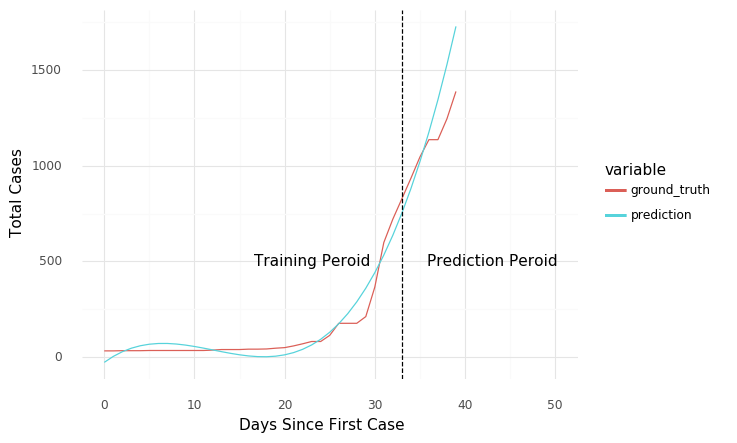

In [17]:
#@title {run: "auto"}
cutting_point = 33 #@param {type:"slider", min:25, max:35, step:1}
nb_coefs = 4 #@param {type:"slider", min:1, max:7, step:1}
get_prediction(poly_func,cutting_point=cutting_point,nb_coefs=nb_coefs);

Total MSE: 2998980.05; Total MAPE: 88.92%
5-day MSE: 4212.26; 5-day MAPE: 0.24%


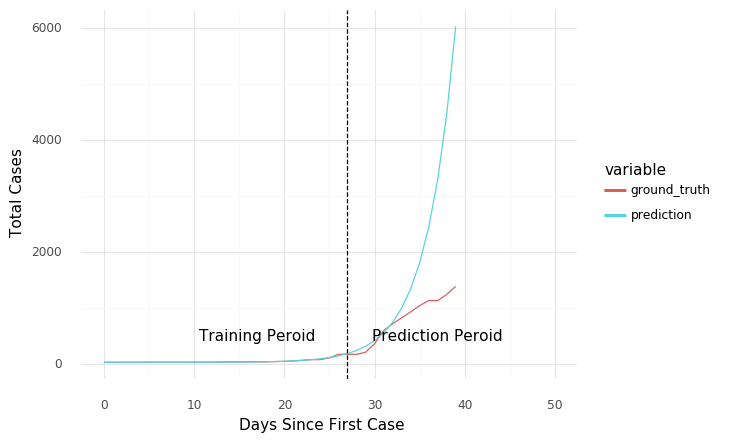

In [18]:
#title {run: "auto"}
cutting_point = 27 #@param {type:"slider", min:25, max:35, step:1}
get_prediction(exp_func,cutting_point=cutting_point,nb_coefs=3);

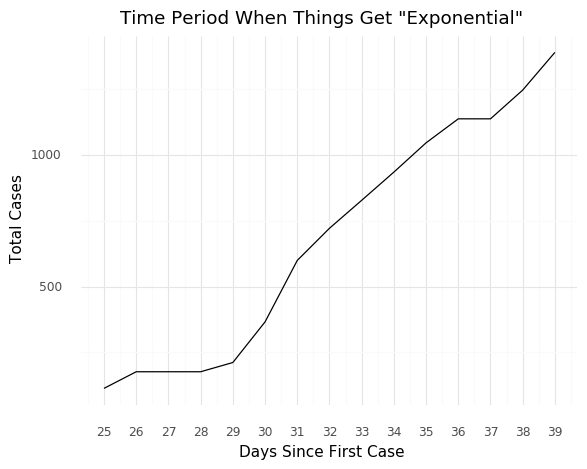

<ggplot: (-9223371865403842844)>

In [19]:
g = (ggplot(th.iloc[25:,[0,5]], aes(x='index',y='total_cases',group=1))+
     geom_line() + theme_minimal() +
     ggtitle('Time Period When Things Get "Exponential"') +
     scale_x_continuous(breaks=[i for i in range(40)])+
     theme(legend_title = element_blank())+
     xlab('Days Since First Case') + ylab('Total Cases'))
g

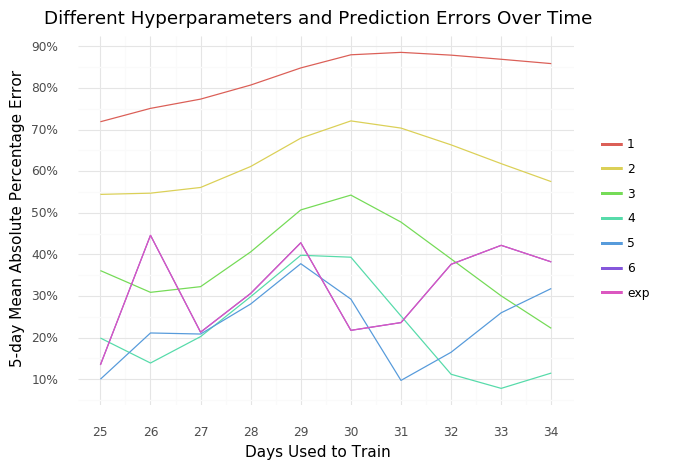

<ggplot: (-9223371865403875588)>

In [21]:
results = []
for cp in range(25,35):
  for nb in range(1,7):
    result = get_prediction(poly_func,cp,nb,5,False)
    results.append({'cutting_point':cp, 'nb_coefs':nb, 'mse': result[2], 'mape': result[3]})
  exp_result = get_prediction(exp_func,cp,3,5,False)
  results.append({'cutting_point':cp, 'nb_coefs':'exp', 'mse': result[2], 'mape': result[3]})
result_df = pd.DataFrame(results)

g = (ggplot(result_df, aes(x='cutting_point',y='mape',
     group='nb_coefs',color='factor(nb_coefs)')) + 
     geom_line() + theme_minimal() +
     ggtitle('Different Hyperparameters and Prediction Errors Over Time') +
     scale_y_continuous(labels=percent_format(), breaks=[i/10 for i in range(10)])+
     scale_x_continuous(breaks=[i for i in range(40)])+
     theme(legend_title = element_blank())+
     xlab('Days Used to Train') + ylab('5-day Mean Absolute Percentage Error'))
g